In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from utils import get_data, get_stationary_data

YEAR_CUTOFFS = [1953, 1958, 1960]

# ARIMA models

This notebook explores a collection of models related to ARIMA, which stands for Autoregressive Integrated Moving Average model. The ARIMA is a combination of models:
* AR model, autoregression, which tries to explain future data with past values
* MA model, moving average (NOT to mix up with rolling averages or rolling mean, sometimes called moving averages), which tries to explain future data with past errors
* Integrated, which refers to the fact that the data is differenced before applying the ARMA model

Indeed, an important notice is to know that some models will be trained on the differenced data, and some will train on the original data. As explored in the EDA notebook (`n1_eda.ipynb`), to make the data stationary I have to difference it twice : first by 1, to nullify the trend, followed by 12, to remove the seasonal effects. See below the plot of the two sets of data I have :

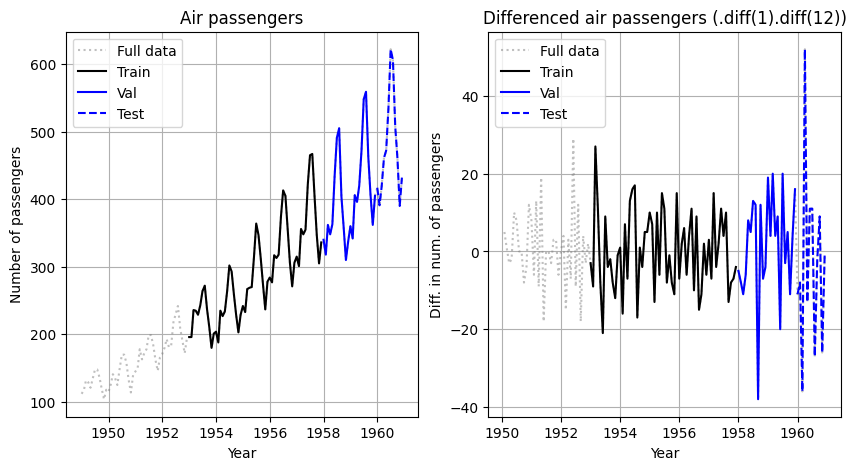

In [2]:
df, train, val, test = get_data(YEAR_CUTOFFS)
s_df, s_train, s_val, s_test = get_stationary_data(YEAR_CUTOFFS)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Air passengers")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Number of passengers")
axs[0].plot(df, color="gray", alpha=0.5, linestyle="dotted", label="Full data")
axs[0].plot(train, color="k", label="Train")
axs[0].plot(val, color="b", label="Val")
axs[0].plot(test, color="b", linestyle="dashed", label="Test")
axs[0].grid()
axs[0].legend()

axs[1].set_title("Differenced air passengers (.diff(1).diff(12))")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Diff. in num. of passengers")
axs[1].plot(s_df, color="gray", alpha=0.5, linestyle="dotted", label="Full data")
axs[1].plot(s_train, color="k", label="Train")
axs[1].plot(s_val, color="b", label="Val")
axs[1].plot(s_test, color="b", linestyle="dashed", label="Test")
axs[1].grid()
axs[1].legend()

plt.show()

And a reminder of the autocorrelation plots, which are useful to determine the orders of the ARIMA models :

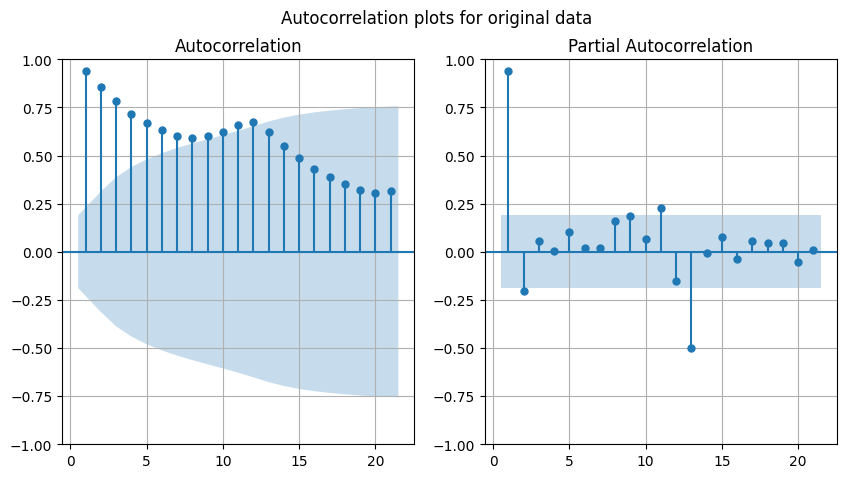

In [3]:
df_excl_val = df.loc[: train.index[-1]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Autocorrelation plots for original data")
plot_acf(df_excl_val, ax=axs[0], zero=False)
axs[0].grid()
plot_pacf(df_excl_val, ax=axs[1], zero=False)
axs[1].grid()
plt.show()

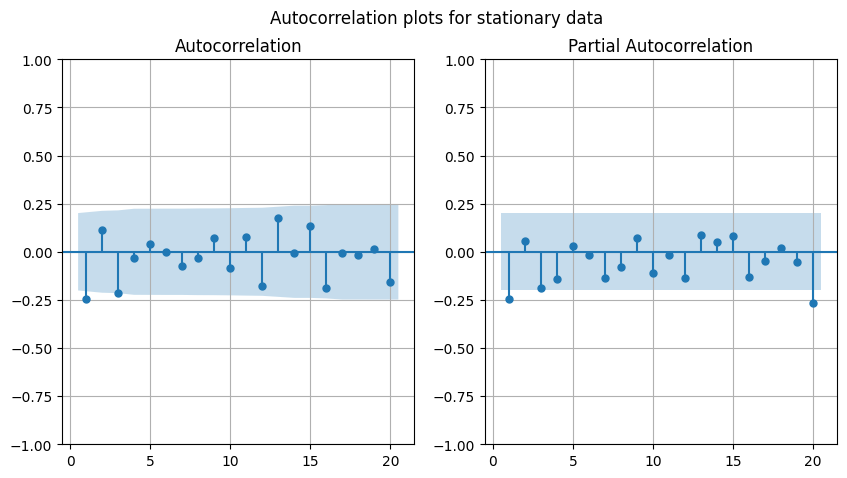

In [4]:
s_df_excl_val = s_df.loc[: s_train.index[-1]].dropna()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Autocorrelation plots for stationary data")
plot_acf(s_df_excl_val, ax=axs[0], zero=False)
axs[0].grid()
plot_pacf(s_df_excl_val, ax=axs[1], zero=False)
axs[1].grid()
plt.show()

# (1) Autoregressive (AR) model

In the Autoregressive (AR) model, each value $y$ at some time $t$ depends on previous values $y$ up to some order $p$, with an extra term accounting for white noise $\epsilon$. See:
$$
y_t = \epsilon_t + \sum_{i=1}^{p} \phi_i y_{t-i}
$$
The model above is denoted AR($p$).

From the partial autocorrelation plot of the original data above, I see that the order $p$ for the AR model should be $p = 1$. Thus, with this air passengers data, I have the AR(1) model:
$$
y_t = \epsilon_t + \phi_1 y_{t-1}
$$

Below is an implementation with the `ARIMA` function of `statsmodels`.

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


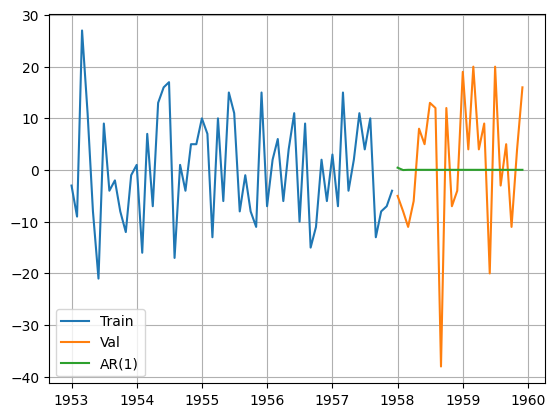

In [5]:
ar_model = ARIMA(s_train, order=(1, 0, 0))
ar_res = ar_model.fit()
ar_res.summary()

ar_pred = ar_res.predict(start=s_val.index[0], end=s_val.index[-1])

plt.plot(s_train, label="Train")
plt.plot(s_val, label="Val")
plt.plot(ar_pred, label="AR(1)")

plt.grid()
plt.legend()
plt.show()

# (2) Moving Average (MA) model

<span style="color:red">**WARNING !** The moving average *model* should NOT be confused with the moving average *smoothing* method. These methods are different in essence : the MA *model* consists of a modelisation of stationary data with the observed deviations of past values, while the MA *smoothing* method, to which I prefer to denote rolling mean (as I have done in the first two notebooks), is an approach that aims to compute the average of values in a window of adjacent points in order to capture the underlying trend and to avoid the effect of noise and seasonal effects.</span>

The MA model consists in predicting stationary univariate data using past forecast errors, like so:
$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} = \mu + \sum_{i=0}^{q} \theta_i \epsilon_{t-i}
$$
with $\theta_0 = 1$.

Above is the expression of a MA model of order $q$, expressed as MA($q$). Our target is the stationary variable $y$ at time $t$. The hypothesis is that $y$ oscillates around some average $\mu$ with the effect of error factors $\epsilon_i$ which follow a normal distribution of null mean and same variance. The coefficients $\theta$ need to be fit with the observations of these past errors.

As shown above in this notebook, only the first lag is significant in the autocorrelation plot of the stationary data. Hence, $q = 1$ with this data, and the MA(1) model is written as
$$
y_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1}.
$$


c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


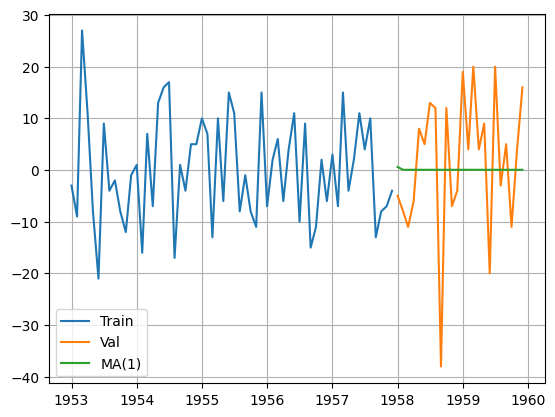

In [6]:
ma_model = ARIMA(s_train, order=(0, 0, 1))
ma_res = ma_model.fit()
ma_pred = ma_res.predict(start=s_val.index[0], end=s_val.index[-1])

plt.plot(s_train, label="Train")
plt.plot(s_val, label="Val")
plt.plot(ma_pred, label="MA(1)")

plt.grid()
plt.legend()
plt.show()

# (3) ARMA model

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


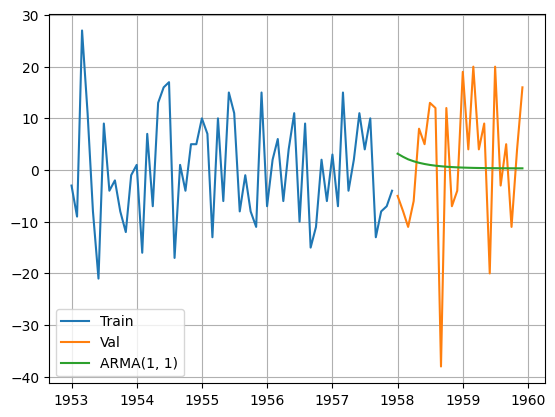

In [7]:
arma_model = ARIMA(s_train, order=(1, 0, 1))
arma_model = arma_model.fit()
arma_pred = arma_model.predict(start=s_val.index[0], end=s_val.index[-1])

plt.plot(s_train, label="Train")
plt.plot(s_val, label="Val")
plt.plot(arma_pred, label="ARMA(1, 1)")

plt.grid()
plt.legend()
plt.show()

# (*) A comment on AR, MA and ARMA

The forecasts shown above don't seem to be good choices for this data. Indeed, the AR, MA and ARMA models try to find some patterns to forecast stationary data, but they won't predict the inherent random noise of the data. So the outputs of these models above just show that no patterns were found that can explain the data at this level.

# (4) ARIMA model

Now, ARIMA model is a combination of an ARMA model with a previous step of differentiation. In this case, I can use orders $p = 1$ and $q = 1$, like in the ARMA model trained in the previous section.

However, my stationary data is actually differenced twice, once by lag 1 and once by lag 12 to remove seasonal effects. Indeed, the ARIMA model is not meant to be used for data with seasonality.

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


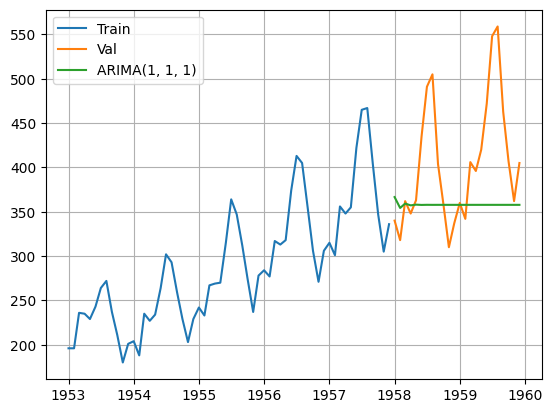

In [8]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_model = arima_model.fit()
arima_pred = arima_model.predict(start=val.index[0], end=val.index[-1])

plt.plot(train, label="Train")
plt.plot(val, label="Val")
plt.plot(arima_pred, label="ARIMA(1, 1, 1)")

plt.grid()
plt.legend()
plt.show()

# (5) SARIMA

The Seasonal ARIMA model, or SARIMA, extends an ARIMA model with 4 extra parameters, or orders, to account for seasonal effects. To start, I need to specify the period in which these seasonal effects are happening. In my case, this is 12 months. Then, new orders $P$, $D$ and $Q$ need to be determined. As a rule of thumb, $D = 1$, which means that the model needs to difference data once by 12 months to get to stationary data. Combined with the non-seasonal order $d = 1$, which differences data by 1 month to remove the trend, this is coherent with the steps followed in previous notebooks.

I can make a decision on $P$ and $Q$ by plotting the autocorrelation plots only for this new seasonal lags.

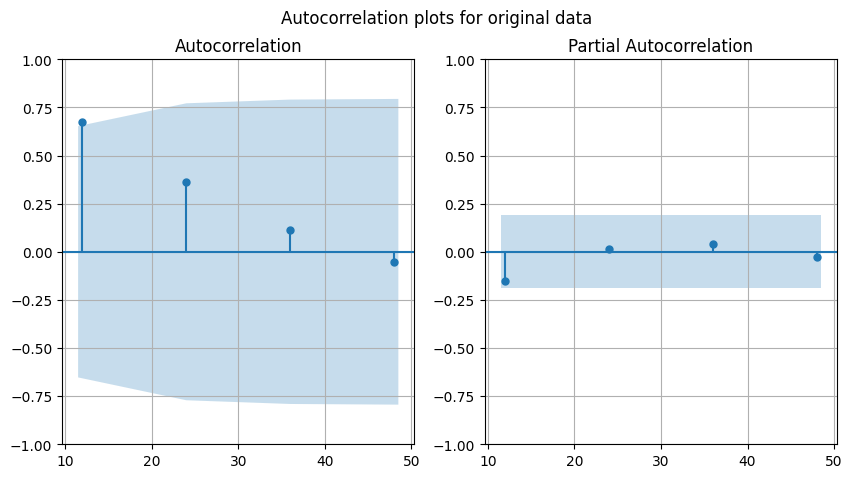

In [9]:
seasonal_lags = [12 * i for i in range(1, 5)]

df_excl_val = df.loc[: train.index[-1]]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Autocorrelation plots for original data")
plot_acf(df_excl_val, ax=axs[0], lags=seasonal_lags)
axs[0].grid()
plot_pacf(df_excl_val, ax=axs[1], lags=seasonal_lags)
axs[1].grid()
plt.show()

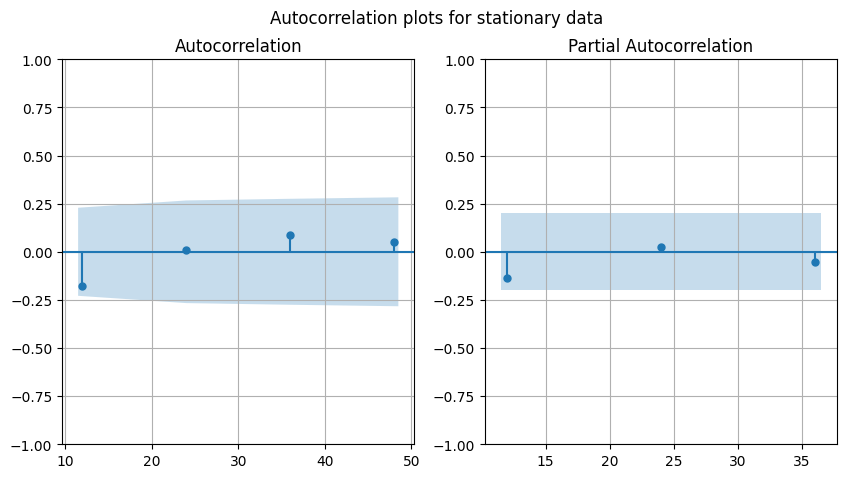

In [10]:
s_df_excl_val = s_df.loc[: s_train.index[-1]].dropna()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Autocorrelation plots for stationary data")
plot_acf(s_df_excl_val, ax=axs[0], lags=seasonal_lags)
axs[0].grid()
plot_pacf(s_df_excl_val, ax=axs[1], lags=seasonal_lags[:-1])
axs[1].grid()
plt.show()

From the plots above, it looks like the seasonal orders should be $P = 0$ and $Q = 0$. Indeed, the partial autocorrelation of the original data does not show significance in the first lag of 12 months. However, $P = 1$ could be tested as well. Concerning the autocorrelation of the "stationarised" data, there is no significance in any lag. $Q = 1$ can be tested as well, as it is the lag with the highest autocorrelation, despite it being inside the cone of uncertainty.

In [11]:
def get_sarima(order, seasonal_order):
    sarima_model = ARIMA(train, order=order, seasonal_order=seasonal_order)
    sarima_model = sarima_model.fit()
    sarima_pred = sarima_model.predict(start=val.index[0], end=val.index[-1])
    return sarima_pred

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(d

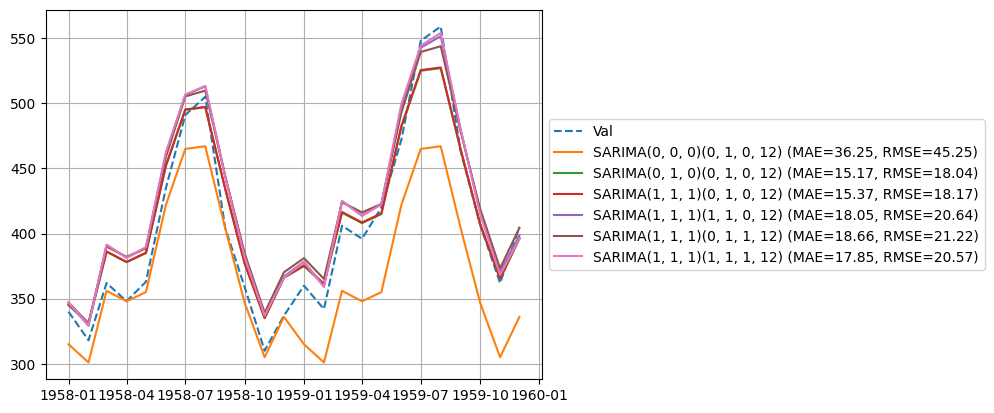

In [12]:
order_pairs = [
    ((0, 0, 0), (0, 1, 0, 12)),
    ((0, 1, 0), (0, 1, 0, 12)),
    ((1, 1, 1), (0, 1, 0, 12)),
    ((1, 1, 1), (1, 1, 0, 12)),
    ((1, 1, 1), (0, 1, 1, 12)),
    ((1, 1, 1), (1, 1, 1, 12)),
]

plt.plot(val, ls="dashed", label="Val")
for order, seasonal_order in order_pairs:
    sarima_pred = get_sarima(order, seasonal_order)
    mae = mean_absolute_error(val, sarima_pred)
    rmse = np.sqrt(mean_squared_error(val, sarima_pred))
    plt.plot(
        sarima_pred,
        label=f"SARIMA{order}{seasonal_order} (MAE={mae:.2f}, RMSE={rmse:.2f})",
    )

plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Just as a test, above I have tried setting all non-seasonal orders to 0 (orange) to show that, indeed, the seasonal effects are predicted with $D = 1$ and period 12, but the trend is not taken into account because $d = 0$. Indeed, just changing this non-seasonal order to $d = 1$ (green) gives a much better result, even if I keep $p = 0$ and $q = 0$.

Trying some values for these seasonal orders shows that the best combination is $(p, d, q)(P, D, Q) = (0, 1, 0)(0, 1, 0)$. However, the metrics show that there is not a significant difference among the results. Indeed, the autocorrelation plots of the stationarised data didn't show significant lags, so the data does not really behave like an AR or a MA model.

In [13]:
sarima_pred = get_sarima((0, 1, 0), (0, 1, 0, 12))

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# (*) AutoARIMA

Of course, there is a package that automatically finds the best parameters for an ARIMA model. As seen above, sometimes the autocorrelation plots suggest some order for the AR and MA terms, but it's not clear, so a couple of tests are needed to determine the best model. However, it's also true that sometimes the difference in performance is not that important.

The function `auto_arima` iterates over a selection of ARIMA models and outputs a list of performances with the metric AIC (the lower the better).

In [14]:
auto_arima(y=train, seasonal=True, m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=348.404, Time=0.37 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=348.359, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=346.069, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=347.985, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=349.130, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=347.910, Time=0.15 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=347.813, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=347.097, Time=0.12 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=349.219, Time=0.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=347.906, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=347.967, Time=0.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=347.530, Time=0.07 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AI

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [15]:
auto_arima_pred = get_sarima((1, 1, 0), (1, 1, 0, 12))

c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\lopezmel\Documents\programming\python\tsa_air_passengers\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Final comparison

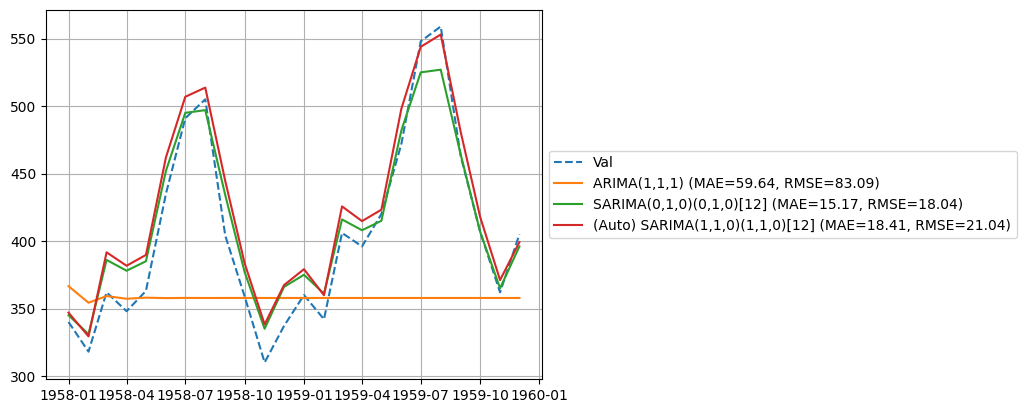

In [16]:
models_to_compare = {
    "ARIMA(1,1,1)": arima_pred,
    "SARIMA(0,1,0)(0,1,0)[12]": sarima_pred,
    "(Auto) SARIMA(1,1,0)(1,1,0)[12]": auto_arima_pred,
}

plt.plot(val, ls="dashed", label="Val")
for model_name in models_to_compare:
    model_pred = models_to_compare[model_name]
    mae = mean_absolute_error(val, model_pred)
    rmse = np.sqrt(mean_squared_error(val, model_pred))
    plt.plot(model_pred, label=f"{model_name} (MAE={mae:.2f}, RMSE={rmse:.2f})")

plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

That's interesting. While the metrics show that the SARIMA model chosen by `auto_arima` is in general worse than my choice of parameters, it is clear that in the months of July and August of 1959 my model is not so precise.

In the end, both models are very close to the validation values, which makes both of them good choices for a forecast for the testing dataset.